<a href="https://colab.research.google.com/github/NurbolSDU/algos/blob/main/DL_HW_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:

!pip -q install torch torchvision torcheval

In [79]:
import os, math, random, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torcheval.metrics import MulticlassAccuracy

random.seed(11)
np.random.seed(11)
torch.manual_seed(11)
torch.cuda.manual_seed_all(11)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [80]:
MNIST_MEAN, MNIST_STD = (0.1307,), (0.3081,)

train_tf = transforms.Compose([
    transforms.RandomCrop(28, padding=2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(MNIST_MEAN, MNIST_STD),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MNIST_MEAN, MNIST_STD),
])

data_root = "./data"

In [81]:
train_ds = datasets.MNIST(root=data_root, train=True, download=True, transform=train_tf)
test_ds  = datasets.MNIST(root=data_root, train=False, download=True, transform=test_tf)


In [82]:
BATCH_SIZE = 128
NUM_WORKERS = 2

In [83]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=512, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)


In [84]:
len(train_ds), len(test_ds)

(60000, 10000)

In [85]:
class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(cin, cout, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(cout),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

In [86]:
class TeacherCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.stem = nn.Sequential(
            ConvBlock(1, 32),
            ConvBlock(32, 32),
        )
        self.block2 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(32, 64),
            ConvBlock(64, 64),
        )
        self.block3 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(64, 128),
            ConvBlock(128, 128),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.head(x)
        return x

In [87]:
model = TeacherCNN().to(DEVICE)
sum(p.numel() for p in model.parameters())/1e6, model

(0.28817,
 TeacherCNN(
   (stem): Sequential(
     (0): ConvBlock(
       (net): Sequential(
         (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU(inplace=True)
       )
     )
     (1): ConvBlock(
       (net): Sequential(
         (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU(inplace=True)
       )
     )
   )
   (block2): Sequential(
     (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (1): ConvBlock(
       (net): Sequential(
         (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU(inplace=True)
       )
 

In [88]:
def accuracy(logits, targets):
    return (logits.argmax(1) == targets).float().mean().item()

In [89]:
@torch.no_grad()
def evaluate(model, loader, device=DEVICE):
    model.eval()
    metric = MulticlassAccuracy(num_classes=10, average="micro").to(device)
    total_loss = 0.0
    n = 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        total_loss += loss.item() * x.size(0)
        n += x.size(0)
        metric.update(logits, y)
    return {"loss": total_loss / n, "acc": metric.compute().item()}


In [90]:
def train_one_epoch(model, loader, optimizer, scheduler=None, device=DEVICE):
    model.train()
    total_loss = 0.0
    n = 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        if scheduler: scheduler.step()

        total_loss += loss.item() * x.size(0)
        n += x.size(0)
    return total_loss / n

In [91]:
EPOCHS = 18
MAX_LR = 1.5e-2
WD = 5e-4

In [92]:
optimizer = torch.optim.AdamW(model.parameters(), lr=MAX_LR, weight_decay=WD)
steps_per_epoch = math.ceil(len(train_loader.dataset) / BATCH_SIZE)

In [93]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=MAX_LR,
    total_steps=EPOCHS * steps_per_epoch,
    pct_start=0.15,
    div_factor=10,
    final_div_factor=100
)

In [94]:
best = {"acc": 0.0, "state": None}
history = []

In [95]:
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer, scheduler)
    val = evaluate(model, test_loader)
    secs = time.time() - t0

    if val["acc"] > best["acc"]:
        best["acc"] = val["acc"]
        best["state"] = {k: v.cpu() for k, v in model.state_dict().items()}

    history.append((epoch, train_loss, val["loss"], val["acc"]))
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} "
          f"| test_loss={val['loss']:.4f} | test_acc={val['acc']*100:.2f}% | {secs:.1f}s")

Epoch 01 | train_loss=0.1852 | test_loss=0.2988 | test_acc=90.27% | 32.7s
Epoch 02 | train_loss=0.0657 | test_loss=0.0867 | test_acc=97.18% | 24.3s
Epoch 03 | train_loss=0.0532 | test_loss=0.0358 | test_acc=98.84% | 25.5s
Epoch 04 | train_loss=0.0413 | test_loss=0.0293 | test_acc=99.01% | 25.0s
Epoch 05 | train_loss=0.0368 | test_loss=0.0246 | test_acc=99.27% | 24.4s
Epoch 06 | train_loss=0.0336 | test_loss=0.0332 | test_acc=98.93% | 24.6s
Epoch 07 | train_loss=0.0276 | test_loss=0.0201 | test_acc=99.32% | 24.1s
Epoch 08 | train_loss=0.0273 | test_loss=0.0241 | test_acc=99.14% | 23.7s
Epoch 09 | train_loss=0.0242 | test_loss=0.0174 | test_acc=99.40% | 24.4s
Epoch 10 | train_loss=0.0213 | test_loss=0.0185 | test_acc=99.42% | 24.2s
Epoch 11 | train_loss=0.0187 | test_loss=0.0169 | test_acc=99.57% | 23.9s
Epoch 12 | train_loss=0.0165 | test_loss=0.0178 | test_acc=99.34% | 24.0s
Epoch 13 | train_loss=0.0137 | test_loss=0.0127 | test_acc=99.53% | 24.0s
Epoch 14 | train_loss=0.0122 | test_lo

In [96]:
if best["state"] is not None:
    model.load_state_dict(best["state"])

final_metrics = evaluate(model, test_loader)
print(f"\nBest Test Accuracy: {final_metrics['acc']*100:.2f}%")


Best Test Accuracy: 99.75%


In [97]:
save_dir = "./teacher_ckpt"
os.makedirs(save_dir, exist_ok=True)

In [98]:
teacher_path = os.path.join(save_dir, "mnist_teacher_cnn.pt")
torch.save({"state_dict": model.state_dict(), "arch": "TeacherCNN"}, teacher_path)
print("Saved teacher to:", teacher_path)

Saved teacher to: ./teacher_ckpt/mnist_teacher_cnn.pt


In [99]:
@torch.no_grad()
def cache_logits(model, loader, device=DEVICE):
    model.eval()
    all_logits = []
    all_targets = []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        all_logits.append(logits.cpu())
        all_targets.append(y.clone())
    return torch.cat(all_logits, dim=0), torch.cat(all_targets, dim=0)

In [100]:
train_plain_ds = datasets.MNIST(root="./data", train=True, download=True,
                                transform=test_tf)
train_plain_loader = DataLoader(train_plain_ds, batch_size=512, shuffle=False,
                                num_workers=NUM_WORKERS, pin_memory=True)

In [101]:
train_logits, train_targets = cache_logits(model, train_plain_loader)
logits_path = os.path.join(save_dir, "mnist_train_logits.pt")
torch.save({"logits": train_logits, "targets": train_targets}, logits_path)
train_logits.shape, train_targets.shape, logits_path

(torch.Size([60000, 10]),
 torch.Size([60000]),
 './teacher_ckpt/mnist_train_logits.pt')

**Step 2**

In [102]:
data = torch.load("./teacher_ckpt/mnist_train_logits.pt")
teacher_logits, targets = data["logits"], data["targets"]
print("Loaded:", teacher_logits.shape, targets.shape)

Loaded: torch.Size([60000, 10]) torch.Size([60000])


In [103]:
class StudentMLP(nn.Module):
    def __init__(self, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, 10)
        )
    def forward(self, x):
        if x.ndim == 4:
            x = x.view(x.size(0), -1)
        return self.net(x)

In [104]:
student = StudentMLP(hidden=256).to(DEVICE)
sum(p.numel() for p in student.parameters())/1e6

0.269322

In [105]:
from torchvision import datasets, transforms

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_tf = test_tf

In [106]:
train_imgs = datasets.MNIST(root="./data", train=True, download=True, transform=train_tf)
train_loader_kd = DataLoader(train_imgs, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

In [107]:
teacher_logits = teacher_logits.to(DEVICE)
targets = targets.to(DEVICE)

In [108]:
def kd_loss(student_logits, teacher_logits, true_labels, T=4.0, alpha=0.5):

    soft_teacher = F.log_softmax(teacher_logits / T, dim=1)
    soft_student = F.log_softmax(student_logits / T, dim=1)
    kd = F.kl_div(soft_student, soft_teacher.exp(), reduction="batchmean") * (T**2)
    ce = F.cross_entropy(student_logits, true_labels)
    return alpha * kd + (1 - alpha) * ce


In [109]:
EPOCHS = 18
LR = 1e-3
ALPHA = 0.7
TEMP = 4.0

In [110]:
opt = torch.optim.AdamW(student.parameters(), lr=LR)
best_acc = 0.0

In [111]:
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=512, shuffle=False)

In [112]:
@torch.no_grad()
def eval_acc(model, loader):
    model.eval()
    correct = total = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / total

In [113]:
for epoch in range(1, EPOCHS + 1):
    student.train()
    t0 = time.time()
    total_loss = 0
    for i, (x, y) in enumerate(train_loader_kd):
        x, y = x.to(DEVICE), y.to(DEVICE)

        batch_logits = teacher_logits[i*128 : i*128 + x.size(0)]
        loss = kd_loss(student(x), batch_logits, y, T=TEMP, alpha=ALPHA)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    acc = eval_acc(student, test_loader)
    print(f"Epoch {epoch:02d} | loss={total_loss/len(train_loader_kd):.4f} | test_acc={acc*100:.2f}% | {time.time()-t0:.1f}s")
    if acc > best_acc:
        best_acc = acc
        torch.save(student.state_dict(), "./student_kd.pt")


Epoch 01 | loss=21.0089 | test_acc=85.32% | 14.4s
Epoch 02 | loss=20.9545 | test_acc=89.43% | 14.2s
Epoch 03 | loss=20.9389 | test_acc=90.30% | 14.3s
Epoch 04 | loss=20.9230 | test_acc=91.92% | 14.2s
Epoch 05 | loss=20.9268 | test_acc=92.57% | 14.8s
Epoch 06 | loss=20.9167 | test_acc=90.60% | 14.0s
Epoch 07 | loss=20.9191 | test_acc=91.41% | 14.3s
Epoch 08 | loss=20.9061 | test_acc=91.83% | 14.4s
Epoch 09 | loss=20.9137 | test_acc=92.00% | 14.2s
Epoch 10 | loss=20.9020 | test_acc=92.91% | 14.3s
Epoch 11 | loss=20.9001 | test_acc=93.23% | 14.2s
Epoch 12 | loss=20.9066 | test_acc=93.55% | 14.5s
Epoch 13 | loss=20.8995 | test_acc=93.84% | 14.5s
Epoch 14 | loss=20.8971 | test_acc=92.74% | 14.2s
Epoch 15 | loss=20.9124 | test_acc=92.65% | 14.3s
Epoch 16 | loss=20.9070 | test_acc=94.01% | 14.4s
Epoch 17 | loss=20.8985 | test_acc=93.80% | 14.2s
Epoch 18 | loss=20.8911 | test_acc=93.88% | 14.5s


In [114]:
print(f"\nBest test accuracy: {best_acc*100:.2f}%")


Best test accuracy: 94.01%


**Step 3**

In [118]:

import os, time, math, copy, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class StudentMLP(nn.Module):
    def __init__(self, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, 10)
        )
    def forward(self, x):
        if x.ndim == 4:
            x = x.view(x.size(0), -1)
        return self.net(x)

student_fp32 = StudentMLP(hidden=256)
ckpt = torch.load("./student_kd.pt", map_location="cpu")
student_fp32.load_state_dict(ckpt if isinstance(ckpt, dict) and "state_dict" not in ckpt else ckpt["state_dict"])
student_fp32.eval();

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

@torch.no_grad()
def eval_acc(model, loader):
    model.eval()
    correct = total = 0
    for x, y in loader:
        x, y = x.to("cpu"), y.to("cpu")
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / total

def model_size_mb(model, path="./_tmp_model.pt"):
    torch.save(model.state_dict(), path)
    mb = os.path.getsize(path) / 1e6
    os.remove(path)
    return mb

def density_percent(model):

    nz, total = 0, 0
    with torch.no_grad():
        for p in model.parameters():
            if p.dtype.is_floating_point:
                total += p.numel()
                nz += (p != 0).sum().item()
    return 100.0 * nz / max(total, 1)

print("Baseline (uncompressed) — acc, size(MB), density(%)")
print(f"{eval_acc(student_fp32, test_loader)*100:.2f}%",
      f"{model_size_mb(student_fp32):.3f} MB",
      f"{density_percent(student_fp32):.2f}%")


Baseline (uncompressed) — acc, size(MB), density(%)
94.01% 1.080 MB 100.00%


In [119]:
import torch.nn.utils.prune as prune

def apply_global_unstructured_pruning(model, prune_pct=0.90):

    m = copy.deepcopy(model)

    params = []
    for mod in m.modules():
        if isinstance(mod, nn.Linear):
            params.append((mod, "weight"))

    prune.global_unstructured(
        params,
        pruning_method=prune.L1Unstructured,
        amount=prune_pct
    )

    for (mod, _) in params:
        prune.remove(mod, "weight")
    return m


PRUNE_PCT = 0.90
student_pruned = apply_global_unstructured_pruning(student_fp32, PRUNE_PCT)

print("After unstructured pruning")
print(f"acc: {eval_acc(student_pruned, test_loader)*100:.2f}%")
print(f"size: {model_size_mb(student_pruned):.3f} MB")
print(f"density: {density_percent(student_pruned):.2f}% (target keep ≈ {(1-PRUNE_PCT)*100:.1f}%)")


os.makedirs("./compressed_ckpt", exist_ok=True)
torch.save(student_pruned.state_dict(), f"./compressed_ckpt/student_pruned_unstructured_{int(PRUNE_PCT*100)}.pt")


After unstructured pruning
acc: 92.32%
size: 1.080 MB
density: 10.17% (target keep ≈ 10.0%)


In [120]:
from torch.ao.quantization import quantize_dynamic

def quantize_linear_dynamic_int8(model_fp32: nn.Module):
    qmodel = quantize_dynamic(
        copy.deepcopy(model_fp32).to("cpu").eval(),
        {nn.Linear},
        dtype=torch.qint8
    )
    return qmodel


to_quantize = student_pruned
student_int8 = quantize_linear_dynamic_int8(to_quantize)

def saved_file_size_mb(module, path="./_tmp_q.pt"):
    torch.save(module.state_dict(), path)
    mb = os.path.getsize(path) / 1e6
    os.remove(path)
    return mb

acc_int8 = eval_acc(student_int8, test_loader)
size_int8 = saved_file_size_mb(student_int8, "./compressed_ckpt/student_int8.pt")

print("After PTQ (dynamic int8)")
print(f"acc: {acc_int8*100:.2f}%")
print(f"size: {size_int8:.3f} MB")

print(f"density (pre-quant float weights): {density_percent(to_quantize):.2f}%")


torch.save(student_int8.state_dict(), "./compressed_ckpt/student_pruned_int8.pt")


/tmp/ipython-input-824485411.py:4: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  qmodel = quantize_dynamic(


After PTQ (dynamic int8)
acc: 92.24%
size: 0.276 MB
density (pre-quant float weights): 10.17%


In [121]:

import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class StudentMLP(nn.Module):
    def __init__(self, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, 10)
        )
    def forward(self, x):
        if x.ndim == 4:
            x = x.view(x.size(0), -1)
        return self.net(x)

student = StudentMLP(hidden=256)
state_dict = torch.load("./compressed_ckpt/student_pruned_unstructured_90.pt", map_location="cpu")
student.load_state_dict(state_dict, strict=False)
student.eval();

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=512, shuffle=False)


In [122]:

import numpy as np, matplotlib.pyplot as plt

@torch.no_grad()
def get_logits_and_labels(model, loader):
    model.eval()
    all_logits, all_labels = [], []
    for x, y in loader:
        logits = model(x)
        all_logits.append(logits)
        all_labels.append(y)
    return torch.cat(all_logits), torch.cat(all_labels)

logits, labels = get_logits_and_labels(student, test_loader)

def expected_calibration_error(logits, labels, n_bins=15):
    probs = torch.softmax(logits, dim=1)
    confs, preds = probs.max(1)
    accs = preds.eq(labels)
    ece = 0.0
    bins = torch.linspace(0, 1, n_bins + 1)
    for i in range(n_bins):
        mask = (confs > bins[i]) & (confs <= bins[i+1])
        if mask.any():
            bin_acc = accs[mask].float().mean()
            bin_conf = confs[mask].mean()
            ece += (mask.float().mean() * torch.abs(bin_acc - bin_conf)).item()
    return ece

ece_before = expected_calibration_error(logits, labels)
print(f"ECE before calibration: {ece_before:.4f}")


ECE before calibration: 0.6501


In [123]:

import torch.optim as optim

def tune_temperature(logits, labels, lr=0.01, max_iter=500):
    T = torch.ones(1, requires_grad=True)
    optimizer = optim.LBFGS([T], lr=lr, max_iter=max_iter)

    def closure():
        optimizer.zero_grad()
        loss = F.cross_entropy(logits / T, labels)
        loss.backward()
        return loss

    optimizer.step(closure)
    return T.detach().item()

T_opt = tune_temperature(logits.clone(), labels.clone())
print(f"Optimal temperature: {T_opt:.3f}")

logits_T = logits / T_opt
ece_after_T = expected_calibration_error(logits_T, labels)
print(f"ECE after temperature scaling: {ece_after_T:.4f}")


Optimal temperature: 0.165
ECE after temperature scaling: 0.0088


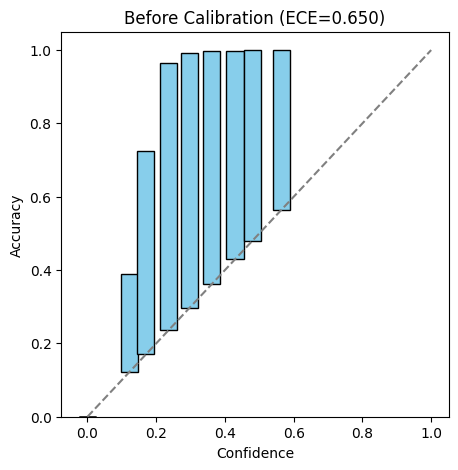

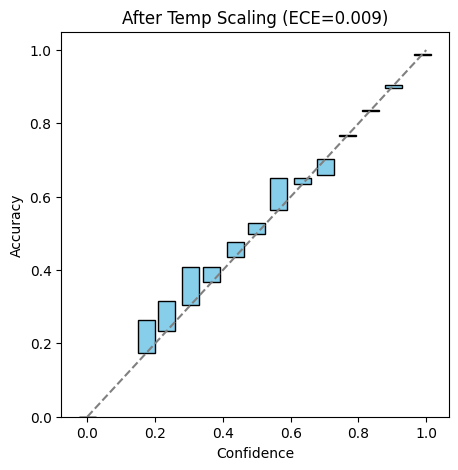

In [124]:

def reliability_diagram(logits, labels, T=None, n_bins=15, title="Reliability"):
    probs = torch.softmax(logits if T is None else logits/T, dim=1)
    confs, preds = probs.max(1)
    accs = preds.eq(labels)

    bins = np.linspace(0, 1, n_bins+1)
    bin_accs, bin_confs = [], []
    for i in range(n_bins):
        mask = (confs > bins[i]) & (confs <= bins[i+1])
        if mask.any():
            bin_accs.append(accs[mask].float().mean().item())
            bin_confs.append(confs[mask].mean().item())
        else:
            bin_accs.append(0)
            bin_confs.append(0)
    plt.figure(figsize=(5,5))
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.bar(bin_confs, np.array(bin_accs)-np.array(bin_confs),
            width=0.05, bottom=bin_confs, color='skyblue', edgecolor='black')
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.show()

reliability_diagram(logits, labels, T=None, title=f"Before Calibration (ECE={ece_before:.3f})")
reliability_diagram(logits, labels, T=T_opt, title=f"After Temp Scaling (ECE={ece_after_T:.3f})")


In [125]:

import os, time, torch, torch.nn as nn, numpy as np, matplotlib.pyplot as plt

def model_size_mb(model, path="./_tmp.pt"):
    torch.save(model.state_dict(), path)
    mb = os.path.getsize(path) / 1e6
    os.remove(path)
    return mb

def density_percent(model):
    nz, total = 0, 0
    with torch.no_grad():
        for p in model.parameters():
            if p.dtype.is_floating_point:
                total += p.numel()
                nz += (p != 0).sum().item()
    return 100.0 * nz / max(total, 1)

@torch.no_grad()
def eval_acc(model, loader):
    model.eval()
    correct = total = 0
    for x, y in loader:
        x, y = x.to("cpu"), y.to("cpu")
        pred = model(x).argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / total

def median_latency_ms_per_sample(model, repeats=300):
    model = model.to("cpu").eval()
    torch.set_num_threads(1)
    xs = [torch.randn(1, 1, 28, 28) for _ in range(repeats)]
    times = []
    with torch.no_grad():
        for x in xs:
            t0 = time.time()
            _ = model(x)
            times.append((time.time() - t0) * 1000.0)
    return float(np.median(times))

def expected_calibration_error(logits, labels, n_bins=15):
    probs = torch.softmax(logits, dim=1)
    confs, preds = probs.max(1)
    accs = preds.eq(labels)
    ece = 0.0
    bins = torch.linspace(0, 1, n_bins + 1)
    for i in range(n_bins):
        mask = (confs > bins[i]) & (confs <= bins[i+1])
        if mask.any():
            bin_acc = accs[mask].float().mean()
            bin_conf = confs[mask].mean()
            ece += (mask.float().mean() * torch.abs(bin_acc - bin_conf)).item()
    return ece


In [126]:

import torch, os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


class StudentMLP(nn.Module):
    def __init__(self, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 10)
        )
    def forward(self, x):
        if x.ndim == 4: x = x.view(x.size(0), -1)
        return self.net(x)

class TeacherCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1,32,3,1,1), nn.ReLU(),
            nn.Conv2d(32,32,3,1,1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.ReLU(),
            nn.Conv2d(64,64,3,1,1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(), nn.Linear(7*7*64,128), nn.ReLU(),
            nn.Linear(128,num_classes)
        )
    def forward(self,x): return self.stem(x)

def safe_load(path):

    obj = torch.load(path, map_location="cpu")
    if isinstance(obj, dict) and "state_dict" in obj:
        return obj["state_dict"]
    elif isinstance(obj, dict):
        return obj
    else:

        return obj.state_dict()

models = {}
models["TeacherCNN"] = safe_load("./teacher_ckpt/mnist_teacher_cnn.pt")
models["Student_KD"] = safe_load("./student_kd.pt")
models["Pruned_90"] = safe_load("./compressed_ckpt/student_pruned_unstructured_90.pt")
models["Quantized_INT8"] = safe_load("/content/compressed_ckpt/student_pruned_int8.pt")


test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=512, shuffle=False)
print("All models loaded successfully")


All models loaded successfully


In [2]:
import torch, torch.nn as nn, torch.nn.functional as F, numpy as np, pandas as pd, time, copy, os

DEVICE = torch.device("cpu")

@torch.no_grad()
def eval_acc(model, loader):
    model.eval()
    correct = total = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / total

def model_size_mb(model, path="./_tmp.pt"):
    torch.save(model.state_dict(), path)
    mb = os.path.getsize(path) / 1e6
    os.remove(path)
    return mb

def density_percent(model):
    nz, total = 0, 0
    with torch.no_grad():
        for p in model.parameters():
            if p.dtype.is_floating_point:
                total += p.numel()
                nz += (p != 0).sum().item()
    return 100.0 * nz / max(total, 1)

def median_latency_ms_per_sample(model, repeats=300):
    try:
        torch.set_num_threads(1)
        torch.set_num_interop_threads(1)
    except Exception as e:
        print("(⚠️ thread config skipped:", e, ")")
    model = copy.deepcopy(model).to("cpu").eval()
    x = torch.randn(1, 1, 28, 28)
    times = []
    with torch.no_grad():
        for _ in range(50):
            _ = model(x)
        for _ in range(repeats):
            t0 = time.time()
            _ = model(x)
            times.append((time.time() - t0) * 1000.0)
    return float(np.median(times))


def expected_calibration_error(logits, labels, n_bins=15):
    probs = F.softmax(logits, dim=1)
    conf, preds = probs.max(1)
    correct = preds.eq(labels)
    ece = torch.zeros(1, device=logits.device)
    for i in range(n_bins):
        lo, hi = i / n_bins, (i + 1) / n_bins
        mask = (conf > lo) & (conf <= hi)
        if mask.any():
            acc = correct[mask].float().mean()
            avg_conf = conf[mask].mean()
            ece += (mask.float().mean()) * torch.abs(acc - avg_conf)
    return ece.item()

class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(cin, cout, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(cout),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class TeacherCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.stem = nn.Sequential(
            ConvBlock(1, 32),
            ConvBlock(32, 32),
        )
        self.block2 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(32, 64),
            ConvBlock(64, 64),
        )
        self.block3 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(64, 128),
            ConvBlock(128, 128),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.head(x)
        return x


class StudentMLP(nn.Module):
    def __init__(self, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 10)
        )
    def forward(self,x):
        if x.ndim == 4: x = x.view(x.size(0), -1)
        return self.net(x)

from torchvision import datasets, transforms
test_tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=test_tf)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=512, shuffle=False)

models = {}

t_ckpt = torch.load("teacher_ckpt/mnist_teacher_cnn.pt", map_location="cpu")
teacher = TeacherCNN()
teacher.load_state_dict(t_ckpt["state_dict"], strict=True)
teacher.eval()
models["TeacherCNN"] = teacher

s_ckpt = torch.load("/content/student_kd.pt", map_location="cpu")
student_kd = StudentMLP(); student_kd.load_state_dict(s_ckpt if "state_dict" not in s_ckpt else s_ckpt["state_dict"]); student_kd.eval()
models["Student_KD"] = student_kd

p_ckpt = torch.load("compressed_ckpt/student_pruned_unstructured_90.pt", map_location="cpu")
student_pruned = StudentMLP(); student_pruned.load_state_dict(p_ckpt if "state_dict" not in p_ckpt else p_ckpt["state_dict"], strict=False); student_pruned.eval()
models["Pruned_90"] = student_pruned

q_ckpt = torch.load("compressed_ckpt/student_pruned_int8.pt", map_location="cpu")
from torch.ao.quantization import quantize_dynamic
student_q = StudentMLP()
student_qint8 = quantize_dynamic(copy.deepcopy(student_q), {nn.Linear}, dtype=torch.qint8)
try:
    student_qint8.load_state_dict(q_ckpt)
except:
    print("⚠️ Quantized model state_dict format differs, using pre-saved quantized version directly.")
models["Quantized_INT8"] = student_qint8

results = []

for name, model in models.items():
    print(f"Evaluating {name} ...")
    logits, labels = [], []
    for x, y in test_loader:
        out = model(x.to(DEVICE))
        logits.append(out)
        labels.append(y)
    logits = torch.cat(logits)
    labels = torch.cat(labels)
    ece = expected_calibration_error(logits, labels)
    acc = eval_acc(model, test_loader)
    size = model_size_mb(model)
    lat = median_latency_ms_per_sample(model)
    dens = density_percent(model)
    results.append((name, size, dens, lat, acc*100, ece))

df = pd.DataFrame(results, columns=["Model","Size (MB)","Density (%)","Latency (ms)","Accuracy (%)","ECE"])
print("\n=== Metrics Summary ===")
print(df.to_string(index=False))


/tmp/ipython-input-1074163622.py:155: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  student_qint8 = quantize_dynamic(copy.deepcopy(student_q), {nn.Linear}, dtype=torch.qint8)


Evaluating TeacherCNN ...
(⚠️ thread config skipped: Error: cannot set number of interop threads after parallel work has started or set_num_interop_threads called )
Evaluating Student_KD ...
(⚠️ thread config skipped: Error: cannot set number of interop threads after parallel work has started or set_num_interop_threads called )
Evaluating Pruned_90 ...
(⚠️ thread config skipped: Error: cannot set number of interop threads after parallel work has started or set_num_interop_threads called )
Evaluating Quantized_INT8 ...
(⚠️ thread config skipped: Error: cannot set number of interop threads after parallel work has started or set_num_interop_threads called )

=== Metrics Summary ===
         Model  Size (MB)  Density (%)  Latency (ms)  Accuracy (%)      ECE
    TeacherCNN   1.167277   100.000000      3.263474         99.75 0.001677
    Student_KD   1.079985   100.000000      0.098348         94.01 0.511968
     Pruned_90   1.079985    10.174438      0.111580         92.32 0.650083
Quantize

In [5]:
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression

def expected_calibration_error(logits, labels, n_bins=15):
    probs = F.softmax(logits, dim=1)
    conf, preds = probs.max(1)
    correct = preds.eq(labels)
    ece = torch.zeros(1, device=logits.device)
    for i in range(n_bins):
        lo, hi = i / n_bins, (i + 1) / n_bins
        mask = (conf > lo) & (conf <= hi)
        if mask.any():
            acc = correct[mask].float().mean()
            avg_conf = conf[mask].mean()
            ece += (mask.float().mean()) * torch.abs(acc - avg_conf)
    return ece.item()

def reliability_diagram(logits, labels, title="Reliability diagram"):
    probs = F.softmax(logits, dim=1)
    conf, preds = probs.max(1)
    correct = preds.eq(labels)
    bins = np.linspace(0, 1, 11)
    accs, confs = [], []
    for i in range(len(bins) - 1):
        mask = (conf > bins[i]) & (conf <= bins[i+1])
        if mask.any():
            accs.append(correct[mask].float().mean().item())
            confs.append(conf[mask].mean().item())
        else:
            accs.append(np.nan)
            confs.append(np.nan)
    plt.figure(figsize=(4,4))
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.plot(confs, accs, marker='o')
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


Optimal temperature: 0.393
ECE pre: 0.6466, post: 0.2674


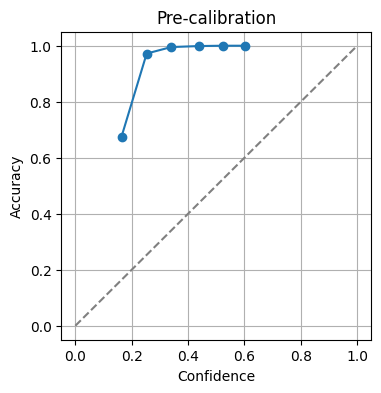

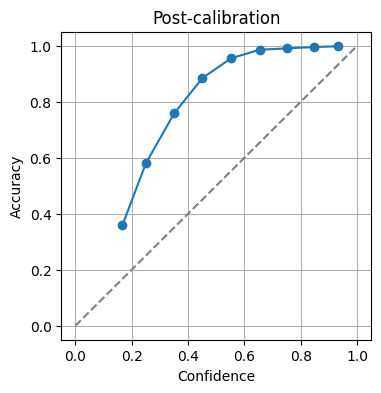

In [6]:
@torch.no_grad()
def temperature_scaling(logits, labels):
    T = torch.ones(1, requires_grad=True)
    optimizer = torch.optim.LBFGS([T], lr=0.01, max_iter=50)

    nll = nn.CrossEntropyLoss()

    def eval_loss():
        optimizer.zero_grad()
        loss = nll(logits / T, labels)
        loss.backward()
        return loss

    optimizer.step(eval_loss)
    return T.detach().item()

model = models["Quantized_INT8"]
logits, labels = [], []
for x, y in test_loader:
    logits.append(model(x))
    labels.append(y)
logits, labels = torch.cat(logits), torch.cat(labels)

ece_pre = expected_calibration_error(logits, labels)
T_opt = temperature_scaling(logits, labels)
ece_post = expected_calibration_error(logits / T_opt, labels)

print(f"Optimal temperature: {T_opt:.3f}")
print(f"ECE pre: {ece_pre:.4f}, post: {ece_post:.4f}")

reliability_diagram(logits, labels, title="Pre-calibration")
reliability_diagram(logits / T_opt, labels, title="Post-calibration")


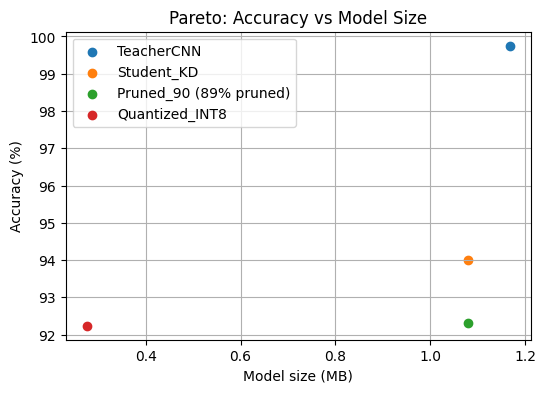

In [7]:
plt.figure(figsize=(6,4))
for name, size, dens, lat, acc, ece in results:
    if "Pruned" in name:
        label = f"{name} ({int(100-dens):d}% pruned)"
        plt.scatter(size, acc, label=label)
    else:
        plt.scatter(size, acc, label=name)
plt.xlabel("Model size (MB)")
plt.ylabel("Accuracy (%)")
plt.title("Pareto: Accuracy vs Model Size")
plt.legend()
plt.grid(True)
plt.show()
